In [1]:
from architecture import VAE
import torch
from torchvision import transforms
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets

transform = transforms.Compose([transforms.ToTensor()])
train_dataset = datasets.FashionMNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.FashionMNIST(root='./data', train=False, download=True, transform=transform)
train_loader = DataLoader(dataset=train_dataset, batch_size=128, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=128, shuffle=False)

In [2]:
def total_loss_function(recon_x, x, mu, logvar):
    recon_loss = F.mse_loss(recon_x, x, reduction='sum')
    kld = 0.5 * torch.sum(mu.pow(2) + logvar.exp() - logvar - 1)
    return recon_loss + kld, recon_loss, kld

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = VAE().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

train_losses = []
val_losses = []
train_accs = []
val_accs = []

for epoch in range(15):
    model.train()
    epoch_train_loss = 0.0
    epoch_recon_loss = 0.0
    epoch_kld_loss = 0.0
    
    for images, _ in train_loader:
        images = images.to(device)
        
        recon_images, mu, logvar = model(images)

        loss, recon_loss, kld_loss = total_loss_function(recon_images, images, mu, logvar)
        loss = recon_loss + 10*kld_loss

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        epoch_train_loss += loss.item()
        epoch_recon_loss += recon_loss.item()
        epoch_kld_loss += kld_loss.item()

    avg_train_loss = epoch_train_loss / len(train_loader)
    train_losses.append(avg_train_loss)

    model.eval()
    epoch_val_loss = 0.0
    epoch_recon_loss = 0.0
    epoch_kld_loss = 0.0
    
    with torch.no_grad():
        for images, _ in test_loader:
            images = images.to(device)
            recon_images, mu, logvar = model(images)

            loss, recon_loss, kld_loss = total_loss_function(recon_images, images, mu, logvar)

            epoch_val_loss += loss.item()
            epoch_recon_loss += recon_loss.item()
            epoch_kld_loss += kld_loss.item()

    avg_val_loss = epoch_val_loss / len(test_loader)
    avg_recon_loss = epoch_recon_loss / len(test_loader)
    avg_kld_loss = epoch_kld_loss / len(test_loader)
    
    val_losses.append(avg_val_loss)

    print(f"Epoch [{epoch+1}/{15}] | Train Loss: {avg_train_loss:.4f} | Val Loss: {avg_val_loss:.4f} "
          f"(Recon: {avg_recon_loss:.4f}, KLD: {avg_kld_loss:.4f})")


Epoch [1/15] | Train Loss: 8010.4330 | Val Loss: 5433.9318 (Recon: 5259.3027, KLD: 174.6291)
Epoch [2/15] | Train Loss: 7058.4238 | Val Loss: 5358.0845 (Recon: 5186.9780, KLD: 171.1065)
Epoch [3/15] | Train Loss: 6979.6555 | Val Loss: 4988.4738 (Recon: 4779.9772, KLD: 208.4966)
Epoch [4/15] | Train Loss: 6954.8354 | Val Loss: 5060.9609 (Recon: 4864.8145, KLD: 196.1463)
Epoch [5/15] | Train Loss: 6946.6860 | Val Loss: 5007.3950 (Recon: 4800.8635, KLD: 206.5315)
Epoch [6/15] | Train Loss: 6928.1764 | Val Loss: 4893.7326 (Recon: 4677.1861, KLD: 216.5465)
Epoch [7/15] | Train Loss: 6904.1409 | Val Loss: 5014.6527 (Recon: 4810.5744, KLD: 204.0782)
Epoch [8/15] | Train Loss: 6891.5404 | Val Loss: 4990.9802 (Recon: 4786.7975, KLD: 204.1827)
Epoch [9/15] | Train Loss: 6893.8275 | Val Loss: 4889.8573 (Recon: 4679.5359, KLD: 210.3213)
Epoch [10/15] | Train Loss: 6887.8750 | Val Loss: 5122.2814 (Recon: 4932.7210, KLD: 189.5604)
Epoch [11/15] | Train Loss: 6880.7658 | Val Loss: 4883.8841 (Recon: 4

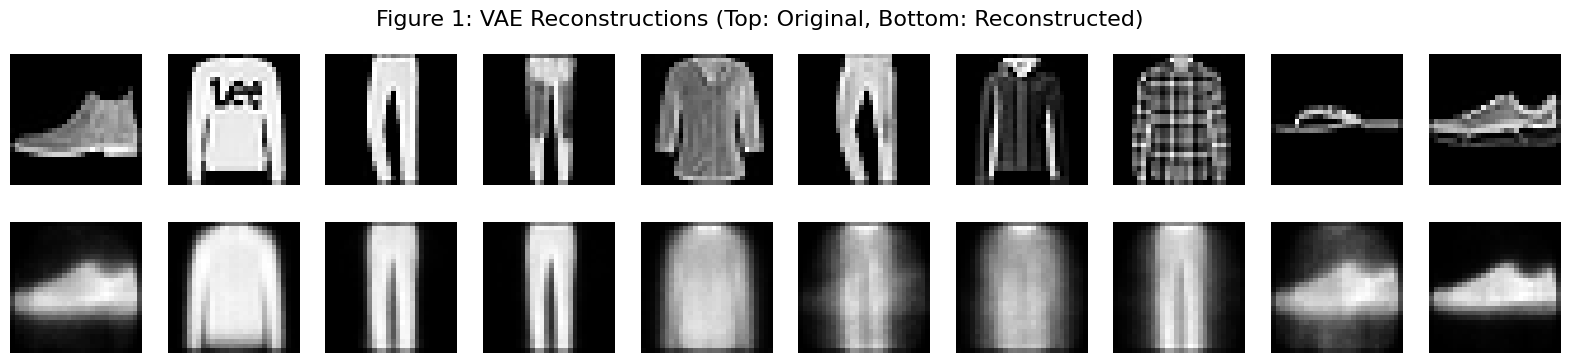

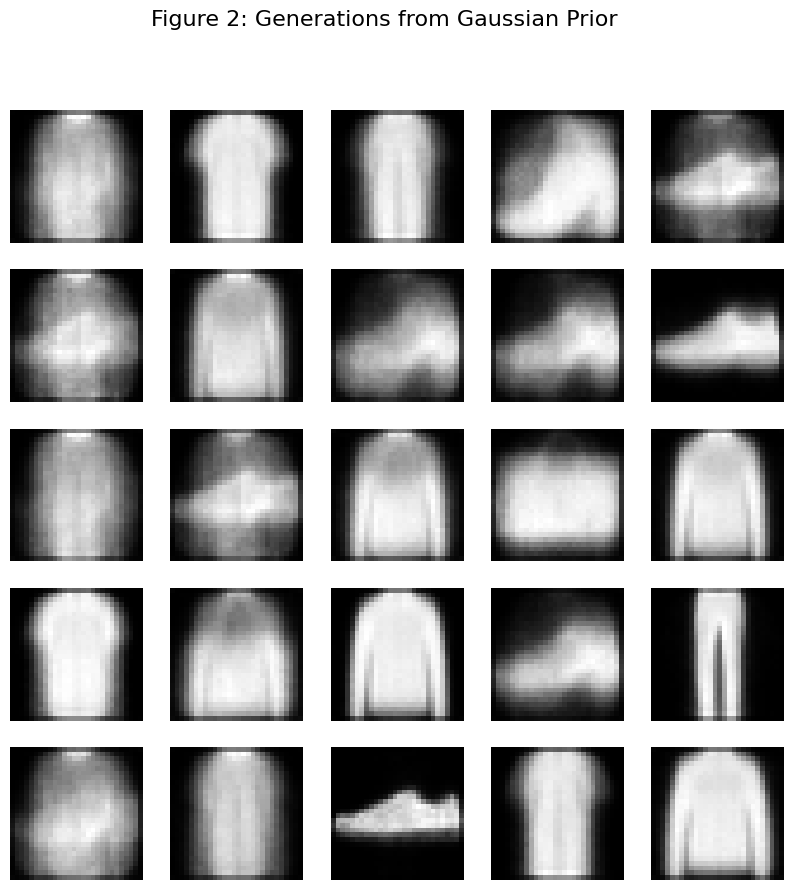

In [4]:
import matplotlib.pyplot as plt
import numpy as np

def plot_reconstructions(model, test_loader, device):
    model.eval()
    with torch.no_grad():
        images, _ = next(iter(test_loader))
        images = images.to(device)
        
        recon_images, _, _ = model(images)

    fig, axes = plt.subplots(nrows=2, ncols=10, figsize=(20, 4))
    plt.suptitle("Figure 1: VAE Reconstructions (Top: Original, Bottom: Reconstructed)", fontsize=16)
    for i in range(10):
        axes[0, i].imshow(images[i].cpu().squeeze(), cmap='gray')
        axes[0, i].axis('off')
        axes[1, i].imshow(recon_images[i].cpu().squeeze(), cmap='gray')
        axes[1, i].axis('off')
    plt.show()

def plot_generations(model, device, latent_dim=20, num_samples=25):
    model.eval()
    with torch.no_grad():
        sample_z = torch.randn(num_samples, latent_dim).to(device)
        title = "Figure 2: Generations from Gaussian Prior"
            
        generated_images = model.decode(sample_z).cpu()

    plt.figure(figsize=(10, 10))
    plt.suptitle(title, fontsize=16)
    grid_size = int(np.sqrt(num_samples))
    for i in range(num_samples):
        ax = plt.subplot(grid_size, grid_size, i + 1)
        plt.imshow(generated_images[i].squeeze(), cmap='gray')
        ax.axis('off')
    plt.show()

plot_reconstructions(model, test_loader, device)

plot_generations(model, device)

Epoch [1/20] | Beta: 0.00 | Train Loss: 3203.5204 | Val Loss: 1713.0325 (Recon: 1713.0325, KLD: 43273.1497)
Epoch [2/20] | Beta: 0.20 | Train Loss: 2610.1295 | Val Loss: 2288.0772 (Recon: 1769.1423, KLD: 2594.6748)
Epoch [3/20] | Beta: 0.40 | Train Loss: 2656.4883 | Val Loss: 2548.5352 (Recon: 1795.8431, KLD: 1881.7302)
Epoch [4/20] | Beta: 0.60 | Train Loss: 2852.6114 | Val Loss: 2784.3444 (Recon: 1837.6854, KLD: 1577.7652)
Epoch [5/20] | Beta: 0.80 | Train Loss: 3059.8197 | Val Loss: 3012.9114 (Recon: 2011.2888, KLD: 1252.0283)
Epoch [6/20] | Beta: 1.00 | Train Loss: 3251.8659 | Val Loss: 3211.6019 (Recon: 2039.5135, KLD: 1172.0884)
Epoch [7/20] | Beta: 1.00 | Train Loss: 3206.0939 | Val Loss: 3154.7504 (Recon: 2035.3109, KLD: 1119.4395)
Epoch [8/20] | Beta: 1.00 | Train Loss: 3162.2056 | Val Loss: 3136.3468 (Recon: 2124.6393, KLD: 1011.7075)
Epoch [9/20] | Beta: 1.00 | Train Loss: 3143.6159 | Val Loss: 3099.5155 (Recon: 2050.4802, KLD: 1049.0353)
Epoch [10/20] | Beta: 1.00 | Train L

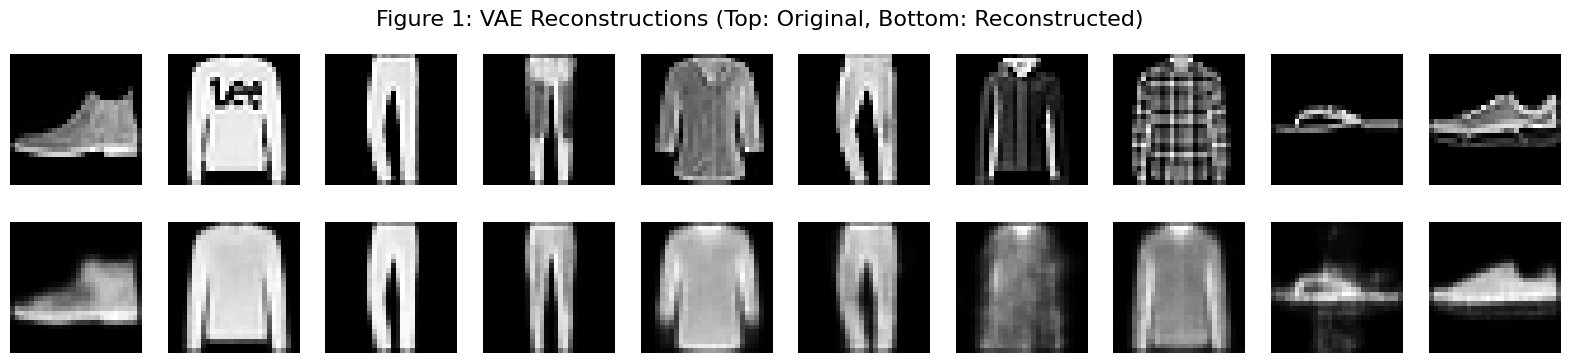

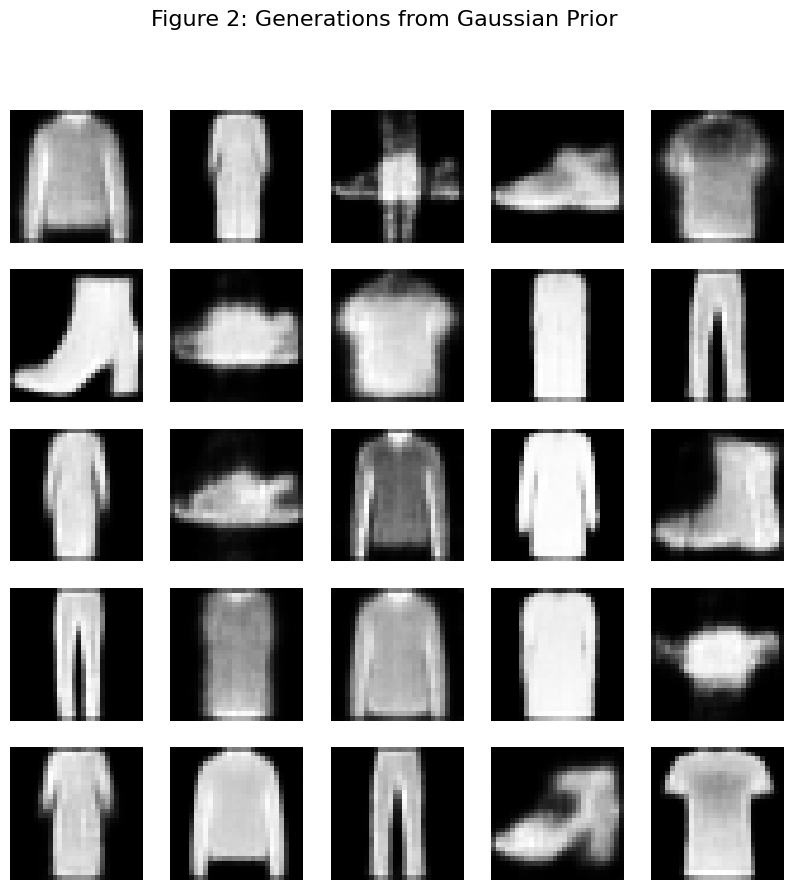

In [5]:
model_annealed = VAE().to(device)
optimizer = torch.optim.Adam(model_annealed.parameters(), lr=1e-3)

ANNEALING_EPOCHS = 5

train_losses = []
val_losses = []
train_accs = []
val_accs = []

for epoch in range(20):
    beta = min(1.0, epoch / ANNEALING_EPOCHS)

    model_annealed.train()
    epoch_train_loss = 0.0
    for images, _ in train_loader:
        images = images.to(device)
        recon_images, mu, logvar = model_annealed(images)
        
        _, recon_loss, kld_loss = total_loss_function(recon_images, images, mu, logvar)
        
        loss = recon_loss + beta * kld_loss 
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        epoch_train_loss += loss.item()

    avg_train_loss = epoch_train_loss / len(train_loader)
    train_losses.append(avg_train_loss)

    model_annealed.eval()
    epoch_val_loss = 0.0
    epoch_recon_loss = 0.0
    epoch_kld_loss = 0.0
    with torch.no_grad():
        for images, _ in test_loader:
            images = images.to(device)
            recon_images, mu, logvar = model_annealed(images)
            _, recon, kld = total_loss_function(recon_images, images, mu, logvar)
            
            epoch_val_loss += (recon.item() + beta * kld.item())
            epoch_recon_loss += recon.item()
            epoch_kld_loss += kld.item()

    avg_val_loss = epoch_val_loss / len(test_loader)
    avg_recon_loss = epoch_recon_loss / len(test_loader)
    avg_kld_loss = epoch_kld_loss / len(test_loader)
    val_losses.append(avg_val_loss)
    print(f"Epoch [{epoch+1}/{20}] | Beta: {beta:.2f} | Train Loss: {avg_train_loss:.4f} | Val Loss: {avg_val_loss:.4f} "
          f"(Recon: {avg_recon_loss:.4f}, KLD: {avg_kld_loss:.4f})")


plot_reconstructions(model_annealed, test_loader, device)
plot_generations(model_annealed, device)